<a href="https://colab.research.google.com/github/HagiwaraNorito/DeepLearning2022Late/blob/main/selenium%E3%81%A7%E7%94%BB%E5%83%8F%E5%8F%8E%E9%9B%862022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#seleniumを使って自動で画像検索し、結果を収集する

##必要なアプリのインストール
Seleniumのインストール（バージョンを指定する）

In [ ]:
!pip install selenium==4.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 958 kB 4.3 MB/s 
     |████████████████████████████████| 140 kB 40.9 MB/s 
     |████████████████████████████████| 384 kB 38.0 MB/s 
     |████████████████████████████████| 4.0 MB 30.6 MB/s 
     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.


##chromium-chromedriverのインストール

In [ ]:
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 20 not upgraded.
Need to get 95.6 MB of archives.
After this operation, 321 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 108.0.5359.71-0ubuntu0.18.04.5 [1,159 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 108.0.5359.71-0ubuntu0.18

#Seleniumを実行して操作する

##その他のライブラリのimport

In [ ]:
import requests
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import os
import time
import datetime
#エラー処理用
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException

/usr/local/lib/python3.8/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


##ログ用に時刻を取得

In [ ]:
tm_start=time.time() #処理時間計測用
dt_now=datetime.datetime.now() #現在日時
dt_date_str=dt_now.strftime('%Y/%m/%d %H:%M') #書式指定
print(dt_date_str)

2022/12/12 02:29


##検索に関する設定値を定義する

In [ ]:
QUERY='犬　フリー' #検索したいキーワード
LIMIT_DL_NUM=100 #ダウンロード数の上限
SAVE_DIR='img/dob_' #出力フォルダ（自動生成させる）
FILE_NAME='dog_' #ファイル名（後ろに連番と拡張子を付けている）
TIMEOUT=60 #検索のタイムアウト（秒）
ACCESS_WAIT=1 #アクセスする感覚（秒）←超重要
RETRY_NUM=3 #クリックやrequestのリトライ回数
DRIVER_PATH='/usr/bin/chromedriver' #chromedriver.exeへのパス

##Chromeをヘッドレスモードで起動する
ヘッドレスモード＝ブラウザを画面に開かないで実行するモード

In [ ]:
#optionの指定を準備
options=Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('start-fullscreen')
options.add_argument('--disable-plugins')
options.add_argument('--disable-extensions')
#起動する
driver=webdriver.Chrome(DRIVER_PATH,options=options)
driver.implicitly_wait(TIMEOUT)
#ログに処理時間を出力
tm_driver=time.time()
print('WebDriver起動完了',f'{tm_driver - tm_start}s')


<ipython-input-6-eb4d5bd2f32c>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome(DRIVER_PATH,options=options)


WebDriver起動完了 0.8290920257568359s


##Googleの画像検索へアクセス

In [ ]:
#QUERY条件付きでURLを定義する
url=f'https://www.google.com/search?q={QUERY}&tbm=isch'
#組み立てたURLでアクセスして検索
driver.get(url)
#時刻のログを取得
tm_geturl=time.time()
print('Google画像検索ページ取得',f'{tm_geturl - tm_driver:1f}s')


Google画像検索ページ取得 2.116894s


##検索結果の要素を取得していく

In [ ]:
#ページのサムネイル画像の要素群を取得
#(islmpクラスが指定されたimg=サムネイルをすべて拾う)
tmb_elems=driver.find_elements_by_css_selector('#islmp img')
#サムネイルのリストから各サムネイルのalt属性を取得していく
tmb_alts=[tmb.get_attribute('alt') for tmb in tmb_elems]
count=len(tmb_alts) - tmb_alts.count('')
print(count)

<ipython-input-8-9e64ab3f4752>:3: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  tmb_elems=driver.find_elements_by_css_selector('#islmp img')


48


##下にスクロールさせてさらに検索結果を表示させてまたカウント

In [ ]:
#定義したLIMIT_DL_NUM（ダウンロード数の上限）になるまでスクロールを繰り返す
while count<LIMIT_DL_NUM:
  #ページの一番下へスクロールして新しいサムネイル画像を表示させる
  driver.execute_script('window.scrollTo(0,document.body.scrollHeight);')
  time.sleep(1) #スリープを繰り返す間隔（秒）
  tmb_elems=driver.find_elements_by_css_selector('#islmp img')
  tmb_alts=[tmb.get_attribute('alt') for tmb in tmb_elems]
  count=len(tmb_alts) - tmb_alts.count('')
  print(count)

<ipython-input-9-e70ef4c96ab7>:6: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  tmb_elems=driver.find_elements_by_css_selector('#islmp img')


100


##サムネイルをクリックすると右側に開かれる領域をオブジェクトに取得

In [ ]:
imgframe_elem=driver.find_element_by_id(('islsp'))

<ipython-input-10-4af9e03f6fd8>:1: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  imgframe_elem=driver.find_element_by_id(('islsp'))


##画像へURLアクセスして保存する準備をする

In [ ]:
os.makedirs(SAVE_DIR,exist_ok=True)
HTTP_HEADERS={'User-Aget':driver.execute_script('return navigator.userAgent;')}
print(HTTP_HEADERS)
IMG_EXTS=('.jpg','.jpeg','.png','gif')

{'User-Aget': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/108.0.5359.71 Safari/537.36'}


#ダウンロード中に利用する関数を定義する
##画像の拡張子を取得する関数

In [ ]:
def get_extension(url):
  url_lower = url.lower()
  for img_ext in IMG_EXTS:
    if img_ext in url_lower:
      extension='.jpg' if img_ext == '.jpeg' else img_ext
      break
    else:
      extension=''
  return extension



In [ ]:
def download_image(url,path,loop):
  result=False
  for i in range(loop):
    try:
      r=requests.get(url,headers=HTTP_HEADERS,stream=True,timeout=10)
      r.raise_for_status()
      with open (path,'wb')as f:
        f.write(r.content)

    except requests.exceptions.SSLError:
      print('****** SSL エラー')
      break
    except requests.exceptions.RequestException as e:
      print(f'****** requests エラー({e}):{i+1}/{RETRY_NUM}')
      time.sleep(1)
    else:
      result=True
      break

  

In [ ]:
tm_thumbnails=time.time()
print('サムネイル画像取得とDL準備完了',f'{tm_thumbnails - tm_geturl:.1f}s')

サムネイル画像取得とDL準備完了 6.0s


0:犬の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK


/usr/local/lib/python3.8/dist-packages/selenium/webdriver/remote/webelement.py:484: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")


ダウンロード 2.3s
------------------------
1:へっくしょん（犬）の写真素材 - ぱくたそ
ダウンロード 3.8s
------------------------
2:犬 | フリー素材ドットコム
ダウンロード 5.2s
------------------------
3:怠惰な秋田犬の写真素材 - ぱくたそ
ダウンロード 6.7s
------------------------
4:犬の写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK
ダウンロード 7.9s
------------------------
5:犬 | フリー素材ドットコム
ダウンロード 9.5s
------------------------
6:フリー写真] 芝生を駆ける二匹の子犬でアハ体験 - GAHAG | 著作権フリー写真・イラスト素材集
****** requests エラー(403 Client Error: Forbidden for url: https://img01.gahag.net/201601/14o/gahag-0046037255.jpg):1/3
****** requests エラー(403 Client Error: Forbidden for url: https://img01.gahag.net/201601/14o/gahag-0046037255.jpg):2/3
****** requests エラー(403 Client Error: Forbidden for url: https://img01.gahag.net/201601/14o/gahag-0046037255.jpg):3/3
ダウンロード 14.1s
------------------------
7:画像素材なら！無料・フリー写真素材のフリーフォト
***** urlチェック:1/3
***** urlチェック:2/3
***** urlチェック:3/3
***** urlに拡張子が含まれていないのでキャンセル

7:犬 ハイタッチの写真素材｜写真素材なら「写真AC」無料（フリー）ダウンロードOK
ダウンロード 16.5s
------------------------
8:無料で使える 犬 フリー素材 - 使える写真ギ
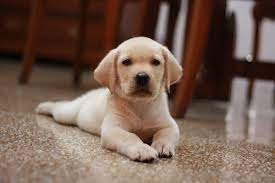
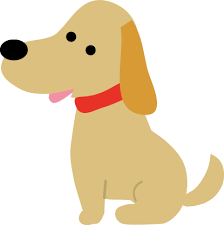

In [ ]:
EXCLUSION_URL='https//lh3.googleusercontent.com/'
count=0
url_list=[]

for tmb_elem,tmb_alt in zip(tmb_elems,tmb_alts):
  if tmb_alt=='':#ALT属性が空＝小さいサムネとみなしてスキップ
    continue 
  print(f'{count}:{tmb_alt}')
  for i in range(RETRY_NUM):

    try:
      tmb_elem.click()
    except ElementClickInterceptedException:
      print(f'***** click エラー:{i + 1}/{RETRY_NUM}')
      driver.execute_script('arguments[0].scrollIntoView(true);',tmb_elem)
      time.sleep
    else:
      break
  else:
    print('***** キャンセル')
    continue
  time.sleep(ACCESS_WAIT)
  alt=tmb_alt.replace("'","\\")
  try:
    img_elem=imgframe_elem.find_element_by_css_selector(f'img[alt=\'{alt}\']')

  except NoSuchElementException:
    print('***** img要素検索エラー')
    print('***** キャンセル')
    continue
  tmb_url=tmb_elem.get_attribute('src')
  
  for i in range(RETRY_NUM):
    url=img_elem.get_attribute('src')
    if EXCLUSION_URL in url:
      print('除外対象url')
      url=''
      break
    elif url == tmb_url:
      print(f'***** urlチェック:{i+1}/{RETRY_NUM}')
    else:
      break
    
  if url == '':
    print('***** キャンセル')
    continue
  ext=get_extension(url)
  if ext == '':
    print(f'***** urlに拡張子が含まれていないのでキャンセル')
    print(f'{url}')
    continue

  filename=f'{FILE_NAME}{count}{ext}'
  path=SAVE_DIR + '/' + filename
  result = download_image(url,path,RETRY_NUM)
  if result == False:
    print('***** キャンセル')
    continue
  url_list.append(f'{filename}:{url}')

  count +=1
  if count >= LIMIT_DL_NUM:
    break
  tm_end=time.time()
  print('ダウンロード',f'{tm_end - tm_thumbnails:.1f}s')
  print('------------------------')


##Colabo上へダウンロードしたファイルを出力する

In [ ]:
total=tm_end - tm_start
total_str = f'とーたる時間:{total:.1f}s({total/60:.2f}min)'
count_str=f'ダウンロード数:{count}'
print(total_str)
print(count_str)

とーたる時間:166.4s(2.77min)
ダウンロード数:94


##Google検索してダウンロードした画像のURLもテキストに保存してローカルPCへ保存する

In [ ]:
#URLを含むテキストファイルの場所
DIR_TMP=SAVE_DIR + '/url/'
os.makedirs(DIR_TMP,exist_ok=True)
path=SAVE_DIR + '/url/' + '_url.txt'
with open( path,'w',encoding='utf-8') as f:
  f.write(dt_date_str + '\n')
  f.write(total_str + '\n')
  f.write(count_str + '\n')
  f.write('\n'.join(url_list))

driver.quit()

##URLテキストと画像ファイルをローカルPCにダウンロード

In [ ]:
!zip -r /content/img_download.zip  /content/img

from google.colab import files
files.download("/content/img_download.zip")


  adding: content/img/ (stored 0%)
  adding: content/img/dob_/ (stored 0%)
  adding: content/img/dob_/dog_28.jpg (deflated 0%)
  adding: content/img/dob_/dog_78.jpg (deflated 1%)
  adding: content/img/dob_/dog_90.jpg (deflated 5%)
  adding: content/img/dob_/dog_79.jpg (deflated 1%)
  adding: content/img/dob_/dog_15.jpg (deflated 1%)
  adding: content/img/dob_/dog_62.jpg (deflated 0%)
  adding: content/img/dob_/dog_3.jpg (deflated 0%)
  adding: content/img/dob_/dog_85.png (deflated 4%)
  adding: content/img/dob_/dog_71.jpg (deflated 1%)
  adding: content/img/dob_/dog_13.png (deflated 0%)
  adding: content/img/dob_/dog_61.jpg (deflated 0%)
  adding: content/img/dob_/dog_58.jpg (deflated 1%)
  adding: content/img/dob_/dog_33.jpg (deflated 1%)
  adding: content/img/dob_/dog_30.jpg (deflated 0%)
  adding: content/img/dob_/dog_25.jpg (deflated 1%)
  adding: content/img/dob_/dog_86.jpg (deflated 6%)
  adding: content/img/dob_/dog_74.jpg (deflated 0%)
  adding: content/img/dob_/dog_10.jpg (def

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>